In [1]:
import geopandas as gpd
import pandas as pd
import eecisc
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
SOURCE_PATH = "/notebooks/sjoin_selection_arcgis.shp"
PROCESSED_PATH = "/notebooks/processed.shp"
ADJACENCY_PATH = "/notebooks/adjacency.csv"

In [3]:
source = eecisc.read_shapefile(SOURCE_PATH)
processed = eecisc.read_shapefile(PROCESSED_PATH)
adjacency = pd.read_csv(eecisc.read_file(ADJACENCY_PATH))

User name on eecisc: tt397
Password: ········
User name on eecisc: tt397
Password: ········
User name on eecisc: tt397
Password: ········


In [4]:
source_only_buildings = source[source.FTC == 1].copy()
source_only_buildings.sort_values(by='GTN', inplace=True)
source_only_buildings.reset_index(inplace=True)

In [5]:
assert source_only_buildings.index.size == processed.index.size
assert (source_only_buildings.GTN == processed.GTN).all()
assert source_only_buildings.geometry.intersects(processed.geometry).all()

The two dataframes refer to the same buildings.

## Polygon Simplification

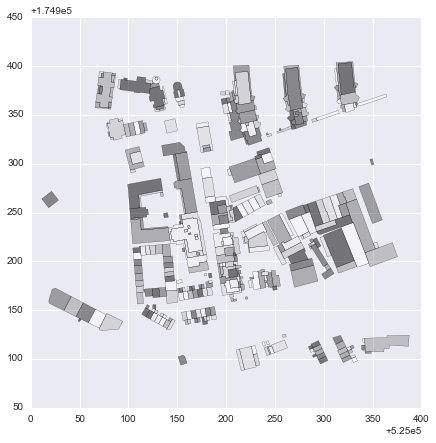

In [6]:
source_only_buildings.plot(linewidth=0.2)

In [7]:
source_only_buildings.area.sum()

30261.282150084091

In [8]:
processed.area.sum()

30248.702050064931

The total floor area of the two dataframes is not equal. That is because the polygons in the ``processed`` dataframe have been simplified.

In [9]:
(source_only_buildings.geometry != processed.geometry).sum()

80

In [10]:
source_only_buildings.index.size

372

80 of 372 buildings are not equal, i.e. 80 of 372 buildings have been touched by ArcGIS.

In [11]:
(source_only_buildings.simplify(0.4).geometry != processed.geometry).sum()

166

In [12]:
mask = source_only_buildings.geometry != processed.geometry
(source_only_buildings[mask].simplify(0.4).geometry != processed[mask].geometry).sum()

42

When applying the ``simplify`` method of ``shapely`` on the raw data, roughly the half of the buildings that have been simplified using ArcGIS receive the same polygon. 

But: roughly 120 of the buildings that were untouched by ArcGIS, have been touched by shapely and hence do not equal the ArcGIS polygons anymore.

In [13]:
source_only_buildings.geometry.map(lambda x: len(x.exterior.coords)).sum()

2919

In [14]:
source_only_buildings.simplify(0.4).geometry.map(lambda x: len(x.exterior.coords)).sum()

2389

In [15]:
processed.geometry.map(lambda x: len(x.exterior.coords)).sum()

2683

In sum, ``shapely`` seems to be more aggressive, as less points remain. 

In [16]:
source_only_buildings.area.sum()

30261.282150084091

In [17]:
source_only_buildings.simplify(0.4).area.sum()

30243.843800087438

In [18]:
processed.area.sum()

30248.702050064931

``shapely`` also removes more total floor are than ArcGIS does.

## Example: Building 6

Building 6 has been processed by both, ArcGIS and shapely.

In [19]:
building6 = source_only_buildings.ix[6].geometry

In [20]:
building6_processed = processed.ix[6].geometry

In [21]:
building6_simplified = source_only_buildings.ix[6].geometry.simplify(0.4)

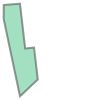

In [22]:
building6

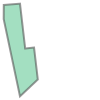

In [23]:
building6_processed

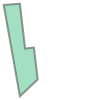

In [24]:
building6_simplified

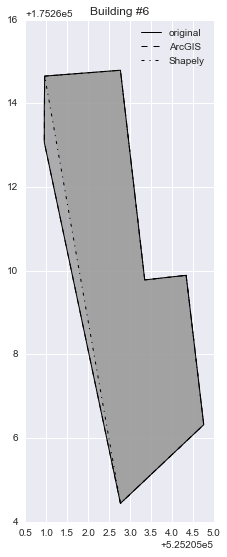

In [25]:
ax = gpd.GeoSeries([building6]).plot(label='original', figsize=(7, 9))
gpd.GeoSeries([building6_processed]).plot(ax=ax, linestyle='--', label='ArcGIS')
gpd.GeoSeries([building6_simplified]).plot(ax=ax, linestyle='-.', label='Shapely')
plt.title('Building #6')
legend = plt.legend()

In [26]:
building6 == building6_processed

False

In [27]:
list(building6.exterior.coords)

[(525209.3399999999, 175269.8900000006),
 (525209.7599999998, 175266.3200000003),
 (525207.7699999996, 175264.43999999948),
 (525205.9500000002, 175273.0700000003),
 (525205.9500000002, 175273.90000000037),
 (525205.96, 175274.65000000037),
 (525207.7699999996, 175274.7899999991),
 (525208.3499999996, 175269.77999999933),
 (525209.3399999999, 175269.8900000006)]

In [28]:
list(building6_processed.exterior.coords)

[(525209.3399999999, 175269.8900000006),
 (525209.7599999998, 175266.3200000003),
 (525207.7699999996, 175264.43999999948),
 (525205.9500000002, 175273.0700000003),
 (525205.96, 175274.65000000037),
 (525207.7699999996, 175274.7899999991),
 (525208.3499999996, 175269.77999999933),
 (525209.3399999999, 175269.8900000006)]

ArcGIS processing delivers a shape that visually matches 100%, no difference can be recognized. Yet, a point has been removed. Shapely delivers an observable difference.

## Conclusion

Replacing ArcGIS polygon simplification with the one from shapely will result in other geometries. While it might be possible to get close in some statistical terms (total floor area, number of vertices), an exact match won't be possible without knowing and implementing ArcGIS algorithm.

# Finding Neighbours

In [29]:
building0 = source_only_buildings.ix[0].geometry

In [30]:
building0_GTN = source_only_buildings.ix[0].GTN

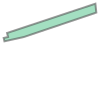

In [31]:
building0

In [32]:
close_buildings = source_only_buildings[source_only_buildings.distance(building0) < 0.01]

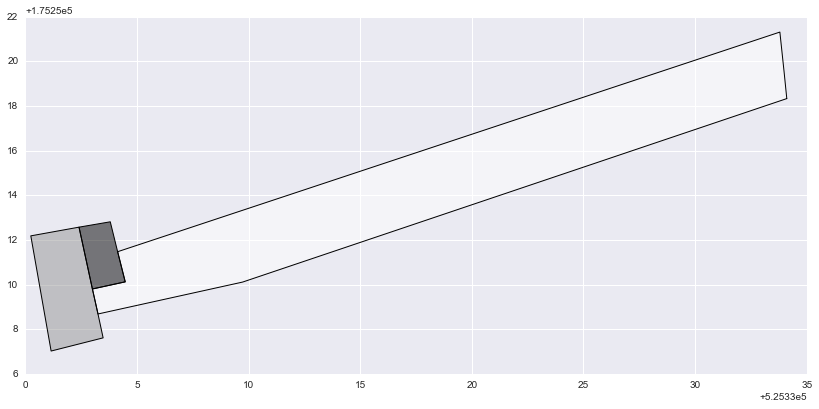

In [33]:
close_buildings.plot()

In [34]:
adjacency[(adjacency.sourceGTN == building0_GTN) | (adjacency.neighbourGTN == building0_GTN)]

,sourceGTN,neighbourGTN,sharedLength
0,9998106,10005880,1.147563
1,9998106,10006585,2.896583


In [35]:
close_buildings.GTN

0      9998106
46    10005880
97    10006585
Name: GTN, dtype: int64

In [36]:
building0.intersection(close_buildings.iloc[1].geometry).length

1.1475626354742046

## Silly Implementation

In [37]:
possible_neighbours = processed.copy()
neighbours = pd.DataFrame(columns=adjacency.columns)